In [1]:
EXEMPLAR_IDX = 5
VID_IDX = 12

In [2]:
import os
import sys
import glob
import numpy as np

from parse import load_ps

import matplotlib.pyplot as plt
from parse import parse_sequence, load_ps
from evaluate import evaluate_pose
import json
import pickle
import pandas as pd
from scipy.signal import medfilt
from scipy.interpolate import CubicSpline
from PyAstronomy import pyaC
from scipy.signal import find_peaks
from tslearn import metrics

In [3]:
def load_joint_data(idx):
    with open(f"C:/Users/jquin/Desktop/BME_Capstone_Lumbly/bird_dog_pkls/vid_{idx}.pkl", 'rb') as f:
        bird_dog_angles = pickle.load(f)
    with open(f"C:/Users/jquin/Desktop/BME_Capstone_Lumbly/bird_dog_pkls/vid_{idx}_filtered.pkl", 'rb') as f:
        bird_dog_angles_filtered = pickle.load(f)
    with open(f"C:/Users/jquin/Desktop/BME_Capstone_Lumbly/bird_dog_pkls/vid_{idx}_vectors.pkl", 'rb') as f:
        bird_dog_vectors = pickle.load(f)
    
    return bird_dog_angles, bird_dog_angles_filtered, bird_dog_vectors

### Unit Direction Vectors

In [4]:
_, _, exemplar_vectors = load_joint_data(EXEMPLAR_IDX)
_, _, query_vectors = load_joint_data(VID_IDX)

In [5]:
exemplar_vectors.keys()

dict_keys(['right_upper_arm_vecs', 'right_torso_vecs', 'right_mid_torso_vecs', 'right_forearm_vecs', 'right_thigh_vecs', 'right_shank_vecs', 'left_upper_arm_vecs', 'left_torso_vecs', 'left_mid_torso_vecs', 'left_forearm_vecs', 'left_thigh_vecs', 'left_shank_vecs'])

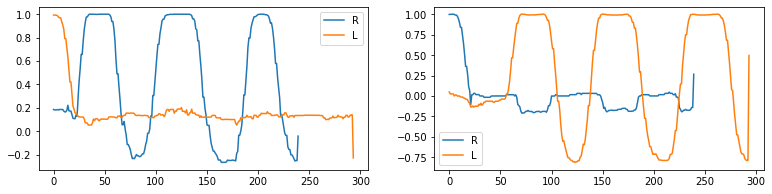

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (13, 3))
ax[0].plot(query_vectors['right_upper_arm_vecs'][:, 0], label = 'R')
ax[0].plot(query_vectors['left_upper_arm_vecs'][:, 0], label = 'L')
ax[0].legend()

ax[1].plot(query_vectors['right_thigh_vecs'][:, 0], label = 'R')
ax[1].plot(query_vectors['left_thigh_vecs'][:, 0], label = 'L')
ax[1].legend()

In [7]:
# right_keys = [key for key in exemplar_vectors.keys() if 'right' in key]
# left_keys = [key for key in exemplar_vectors.keys() if 'left' in key]

# for rkey, lkey in zip(right_keys, left_keys):
#     plt.figure()
#     plt.plot(query_vectors[rkey][:, 0], label = 'R')
#     plt.plot(query_vectors[lkey][:, 0], label = 'L')
#     plt.legend()
#     plt.title(rkey)

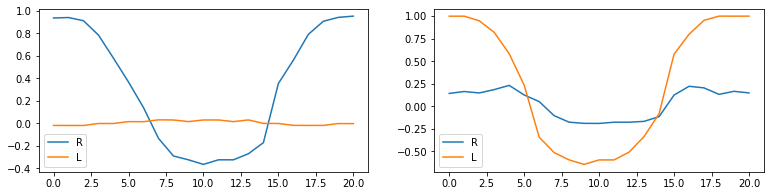

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (13, 3))
ax[0].plot(exemplar_vectors['right_upper_arm_vecs'][:, 0], label = 'R')
ax[0].plot(exemplar_vectors['left_upper_arm_vecs'][:, 0], label = 'L')
ax[0].legend()

ax[1].plot(exemplar_vectors['right_thigh_vecs'][:, 0], label = 'R')
ax[1].plot(exemplar_vectors['left_thigh_vecs'][:, 0], label = 'L')
ax[1].legend()

In [9]:
from tslearn import metrics
from scipy.signal import find_peaks

short_sequence = exemplar_vectors['left_thigh_vecs']
long_sequence = query_vectors['left_thigh_vecs']



In [10]:
# Eqn 1.
def get_FR(feature):
    return np.sum(np.abs(np.diff(feature)))

def get_FRS(exemplar_vectors):
    FRS = {}
    for key in exemplar_vectors.keys():
        for coord in [0, 1]:
            feat_ranking = get_FR(exemplar_vectors[key][:, coord])
            FRS[f"{key}_{coord}"] = {'FR': feat_ranking, 'TCT': 0}
    return pd.DataFrame(FRS).T

FRS = get_FRS(exemplar_vectors)

In [11]:
# Eqn 2. 
def get_TCT(FR, max_FRS, DM = 0.1, DB = 0.3):
    return ((FR/max_FRS)*DM) + DB

# Eqn 3.
def get_minscale(DF, min_scale_perc = 0.08):
    return (max(DF) - min(DF))*min_scale_perc

In [12]:
# Get FR and TCT of each motion feature (TOP ONE IS USED FOR ALIGNMENT)
max_FRS = max(FRS['FR'])
FRS['TCT'] = FRS['FR'].apply(lambda x: get_TCT(x, max_FRS))
FRS = FRS.sort_values(by = 'FR', ascending = False)
FRS

,FR,TCT
left_thigh_vecs_0,3.286760,0.400000
right_upper_arm_vecs_0,2.626525,0.379912
left_thigh_vecs_1,2.481019,0.375485
right_torso_vecs_1,1.813904,0.355188
left_shank_vecs_1,1.794683,0.354603
right_upper_arm_vecs_1,1.462774,0.344505
right_forearm_vecs_1,1.257137,0.338249
right_shank_vecs_1,1.225113,0.337274
right_thigh_vecs_0,1.094957,0.333314
left_torso_vecs_1,0.690443,0.321007


In [13]:
# Cubic interpolation + derivative
def get_DTW_spline(feature, step = 0.1):
    x = range(len(feature))
    xs = np.arange(0, max(x), step)
    cubic_spline = CubicSpline(x, feature)
    
    return xs, cubic_spline(xs), np.gradient(cubic_spline(xs))

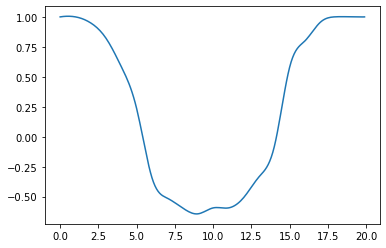

In [14]:
# def get_top_ranking_motion_ft():
    
exemplar_feature = exemplar_vectors['left_thigh_vecs'][:, 0]
xs, exemplar_spline, dt = get_DTW_spline(exemplar_feature)

plt.plot(xs, exemplar_spline)
# plt.scatter(xs[184], exemplar_spline[184])

In [15]:
MIN_SCALE = get_minscale(exemplar_feature)
MIN_SCALE

0.13147360440931466

In [16]:
# xc, xi = pyaC.zerocross1d(xs, dt, getIndices=True)
# plt.scatter(xs[xi], exemplar_spline[xi], marker = '.', color = 'red')
# plt.plot(xs, exemplar_spline)


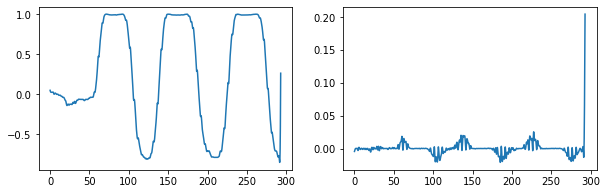

In [17]:
query_feature = query_vectors['left_thigh_vecs'][:, 0]
xs, query_spline, dt = get_DTW_spline(query_feature)

fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(xs, query_spline)
ax[1].plot(xs, dt)

In [18]:
# Get zero-velocity crossings in the observation
xc, xi = pyaC.zerocross1d(xs, dt, getIndices=True)
len(xc), len(xi)

# First and last values in DTW spline
xi = np.append(xi, [0, len(xs) - 1])

# Points that cross first value in exemplar DTW spline
first_val_crossings = np.where(query_spline == exemplar_feature[0])[0]
if first_val_crossings.shape[0] > 0:
    xi = np.append(xi, first_val_crossings)
xi = np.sort(xi)
len(xi)

173

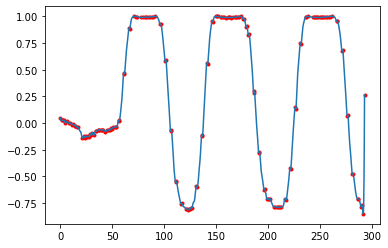

In [19]:
# Plot candidates
plt.plot(xs, query_spline)
plt.scatter(xs[xi], query_spline[xi], marker = '.', color = 'red')
# plt.axhline(y = exemplar_spline[0], linestyle = '--', color = 'red')

In [20]:
# QUERY = EXEMPLAR REPETITION
# CANDIDATE = POSSIBLE PT ON OBSERVATION THAT MAY REPRESENT A SEGMENTATION

### ALT IMPLEMENTATION

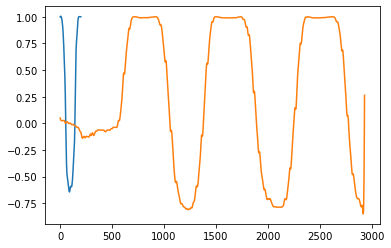

In [21]:
plt.plot(exemplar_spline)
plt.plot(query_spline)

In [22]:
exemplar_feature

array([ 0.9993045 ,  0.99932587,  0.94864163,  0.82054673,  0.58322177,
        0.23469229, -0.34168974, -0.51254369, -0.59400185, -0.64349715,
       -0.59400232, -0.5939839 , -0.50741901, -0.3347686 , -0.08301763,
        0.5779513 ,  0.79859433,  0.95334836,  0.99992291,  0.99965779,
        0.99988859])

In [23]:
mat = metrics.subsequence_cost_matrix(exemplar_feature, query_feature)

# Calculate cost function
cost_func = mat[-1, :]

# # Identify potential matches in the cost function (parameters are tuned to
# # fit this example)
# potential_matches = find_peaks(-cost_func, distance=100 * 0.75, height=-50)[0]

# potential_matches
# # # Calculate the optimal warping path starting from each of the identified
# # # minima
# # paths = [metrics.subsequence_path(mat, match) for match in
# #          potential_matches]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'shape' of type float64
[1m
File "..\..\..\Anaconda3\lib\site-packages\tslearn\metrics\dtw_variants.py", line 18:[0m
[1mdef _local_squared_dist(x, y):
    <source elided>
    dist = 0.
[1m    for di in range(x.shape[0]):
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at c:\Users\jquin\Anaconda3\lib\site-packages\tslearn\metrics\dtw_variants.py (18)[0m
[1m
File "..\..\..\Anaconda3\lib\site-packages\tslearn\metrics\dtw_variants.py", line 18:[0m
[1mdef _local_squared_dist(x, y):
    <source elided>
    dist = 0.
[1m    for di in range(x.shape[0]):
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _local_squared_dist at 0x0000017938EAD310>))[0m
[0m[1mDuring: typing of call at c:\Users\jquin\Anaconda3\lib\site-packages\tslearn\metrics\dtw_variants.py (769)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _local_squared_dist at 0x0000017938EAD310>))[0m
[0m[1mDuring: typing of call at c:\Users\jquin\Anaconda3\lib\site-packages\tslearn\metrics\dtw_variants.py (769)
[0m
[1m
File "..\..\..\Anaconda3\lib\site-packages\tslearn\metrics\dtw_variants.py", line 769:[0m
[1mdef _subsequence_cost_matrix(subseq, longseq):
    <source elided>
        for j in range(l2):
[1m            cum_sum[i + 1, j + 1] = _local_squared_dist(subseq[i], longseq[j])
[0m            [1m^[0m[0m


In [188]:
# Extract segment candidates
def get_segment_candidates():
    pass
    # zero_celoc

# Eqn. 4
def normalize(seq):
    mu = np.mean(seq)
    sigma = np.std(seq)
    return (seq - mu)/sigma

In [191]:
# l = len(xi) - 1
# iter = l
# ss = []
# while iter > 0:
#     # Subsequence of candidate
#     coords = xs[xi[iter]:xi[l]]
#     S = query_spline[xi[iter]:xi[l]]
#     S = normalize(S)
#     if iter % 10 == 0:
#         plt.figure()
#         plt.plot(coords, S)
#         # plt.title(len(S))
#     ss.append(len(S))
#     iter -= 1

In [192]:
# plt.plot(xs, normalize(query_spline))

In [114]:
def get_warp_path():

def get_total_cost():
    pass

def algorithm_1(C, Q):
    """
    FOR A SINGLE TIME STEP -> FIND OPTIMAL WARP PATH
    Q -> query subsequence (exemplar)
    C -> subsequence candidate points (xi in our case)
    """
    m = len(Q)
    l = len(C)

    Q = normalize(Q)
    OW = []
    OTC = 1e10

    # for (int i = l; i > 0; i--):
    iter = l
    while iter > 0:
        # Subsequence of candidate
        S = query_spline[C[iter]:C[l] - 1]
        # Motion must be significant enough (see eqn 3)
        if max(S) - min(S) < MIN_SCALE:
            continue
        S = normalize(S)
        W, A = get_warp_path(Q, S) # A is costs matrix
        TC = get_total_cost(W, A, m)
        if TC < OTC:
            OTC = TC
            OW = W
        iter -= 1

SyntaxError: unexpected EOF while parsing (<ipython-input-114-4d1cf5cf5678>, line 1)

# Run all angles

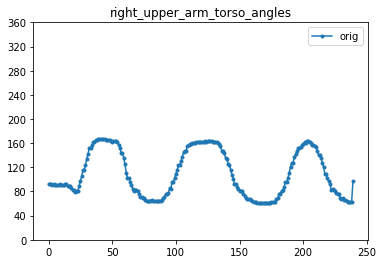

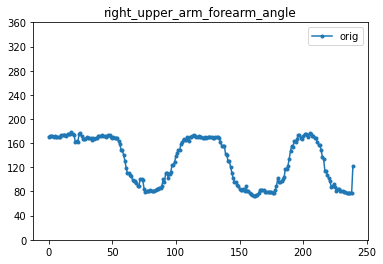

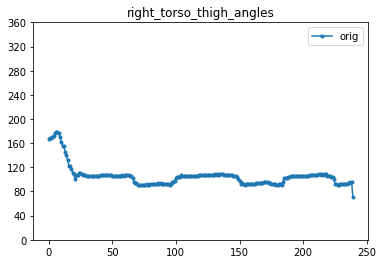

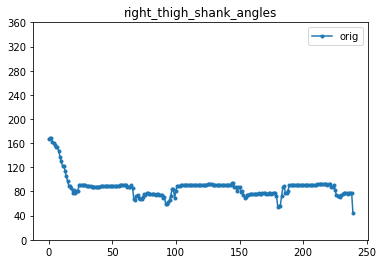

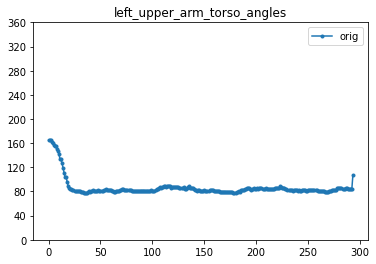

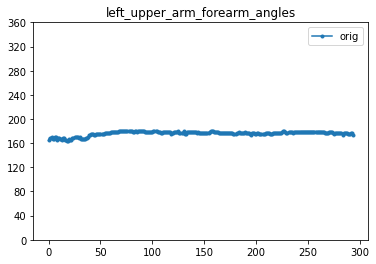

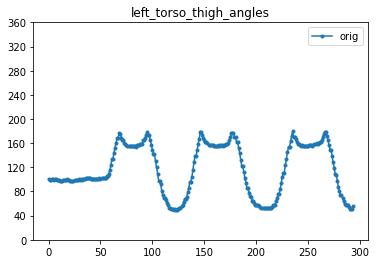

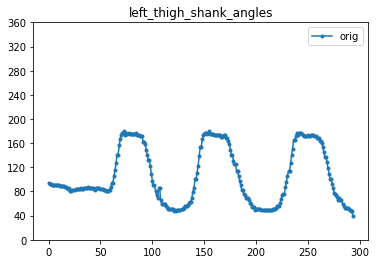

In [33]:
figure_num = 0
# try:
#     os.mkdir("C:/Users/jquin/Desktop/BME_Capstone_Lumbly/TestPlots/AllAngles/{}".format(VID_IDX))
# except:
#     print("Directory Exists")
for key in bird_dog_angles.keys():
    angle = key

    plt.figure(figure_num)
    plt.plot(
        range(len(bird_dog_angles[angle])), 
        bird_dog_angles[angle],
        label = 'orig',
        marker = '.'

    )
    # plt.plot(    
    #     range(len(bird_dog_angles_filtered[angle])), 
    #     bird_dog_angles_filtered[angle],
    #     label = 'filtered',
    #     marker = '.'
    # )
    plt.title(key)
    plt.yticks(np.linspace(0, 360, 10))
    plt.legend()
    # plt.savefig('C:/Users/jquin/Desktop/BME_Capstone_Lumbly/TestPlots/AllAngles/{}/{}.png'.format(VID_IDX, key))
    figure_num += 1
# 

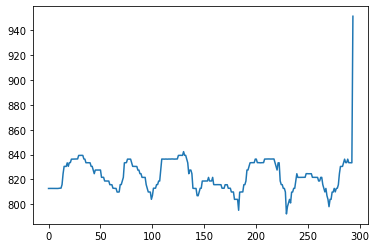

In [45]:
x = np.load('C:/Users/jquin/Desktop/BME_Capstone_Lumbly/bird_dog_npy/vid_12.npy')[:, 2, 0]
plt.plot(x)

In [76]:
bird_dog_angles.keys()


dict_keys(['right_upper_arm_torso_angles', 'right_upper_arm_forearm_angle', 'right_torso_thigh_angles', 'right_thigh_shank_angles', 'left_upper_arm_torso_angles', 'left_upper_arm_forearm_angles', 'left_torso_thigh_angles', 'left_thigh_shank_angles'])

In [107]:
glob.glob(json_files)

['C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_0\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_1\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_10\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_11\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_12\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_2\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_3\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_4\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_5\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_6\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_7\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_8\\',
 'C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons\\vid_9\\']

In [150]:
json_files = "C:/Users/jquin/Desktop/BME_Capstone_Lumbly/JSON/bird_dog_jsons/old/*/"
stationary_arms =     ['right', 'left', 'right', 'right', 'left', 'left']
moving_arms =         ['left', 'right', 'left', 'left', 'right','right']
stationary_legs =     ['left', 'right', 'left', 'left', 'right', 'right']
moving_legs =         ['right', 'left', 'right', 'right', 'left', 'left']

stationary_arm_ranges, moving_arm_ranges = [], []
stationary_leg_ranges, moving_leg_ranges = [], []
# For 4, we do 2 reps, so just take the first: (cut off at around 18)
# For 6, cut off at around 50
results_dicts = []
for vid_idx, (vid_folder, moving_arm, stationary_arm, moving_leg, stationary_leg) in enumerate(zip(json_files, moving_arms, stationary_arms, moving_legs, stationary_legs)):
    # if vid_idx != 2:
        vid_dict = {}
        
        # Note: we use the filtered angles
        with open(f"C:/Users/jquin/Desktop/BME_Capstone_Lumbly/bird_dog_pkls/old/vid_{vid_idx}_filtered.pkl", 'rb') as f:
            bird_dog_angles = pickle.load(f)
        if vid_idx == 4:
            cutoff_idx = 18
            right_arm_angles = bird_dog_angles['right_upper_arm_torso_angles'][:cutoff_idx]
            right_arm_range = np.max(right_arm_angles) - np.min(right_arm_angles)

            left_arm_angles = bird_dog_angles['left_upper_arm_torso_angles'][:cutoff_idx]
            left_arm_range = np.max(left_arm_angles) - np.min(left_arm_angles)

            right_leg_angles = bird_dog_angles['right_torso_thigh_angles'][:cutoff_idx]
            right_leg_range = np.max(right_leg_angles) - np.min(right_leg_angles)

            left_leg_angles = bird_dog_angles['left_torso_thigh_angles'][:cutoff_idx]
            left_leg_range = np.max(left_leg_angles) - np.min(left_leg_angles)
        else:
            right_arm_angles = bird_dog_angles['right_upper_arm_torso_angles']
            right_arm_range = np.max(right_arm_angles) - np.min(right_arm_angles)

            left_arm_angles = bird_dog_angles['left_upper_arm_torso_angles']
            left_arm_range = np.max(left_arm_angles) - np.min(left_arm_angles)

            right_leg_angles = bird_dog_angles['right_torso_thigh_angles']
            right_leg_range = np.max(right_leg_angles) - np.min(right_leg_angles)

            left_leg_angles = bird_dog_angles['left_torso_thigh_angles']
            left_leg_range = np.max(left_leg_angles) - np.min(left_leg_angles)
        
        vid_dict["Video"] = vid_idx
        vid_dict["Right Arm Range"] = right_arm_range
        vid_dict["Left Arm Range"] = left_arm_range
        vid_dict["Right Leg Range"] = right_leg_range
        vid_dict["Left Leg Range"] = left_leg_range
        
        vid_dict["Moving Arm"] = moving_arm
        vid_dict["Stationary Arm"] = stationary_arm
        vid_dict["Moving Leg"] = moving_leg
        vid_dict["Stationary Leg"] = stationary_leg
        results_dicts.append(vid_dict)

In [151]:
results_dict_t = {k: [dic[k] for dic in results_dicts] for k in results_dicts[0]}
results_df = pd.DataFrame(results_dict_t)
results_df

,Video,Right Arm Range,Left Arm Range,Right Leg Range,Left Leg Range,Moving Arm,Stationary Arm,Moving Leg,Stationary Leg
0,0,4.794213,84.570179,51.766954,57.328967,left,right,right,left
1,1,107.353415,15.587173,6.038669,83.283371,right,left,left,right
2,2,33.867290,0.000000,12.962632,0.000000,left,right,right,left
3,3,7.633713,90.423085,77.536021,11.824647,left,right,right,left
4,4,99.367403,5.905081,5.435153,84.065849,right,left,left,right
5,5,80.968220,8.676727,22.643618,103.657964,right,left,left,right


In [129]:
def max_row_val(row, col1, col2):
   return max(row[col1], row[col2])

def min_row_val(row, col1, col2):
   return min(row[col1], row[col2])

results_df['Moving_Arm_Range'] = results_df[['Right Arm Range', 'Left Arm Range']].apply(max_row_val, args=('Right Arm Range', 'Left Arm Range'), axis = 1)
results_df['Stationary_Arm_Range'] = results_df[['Right Arm Range', 'Left Arm Range']].apply(min_row_val, args=('Right Arm Range', 'Left Arm Range'), axis = 1)

results_df['Moving_Leg_Range'] = results_df[['Right Leg Range', 'Left Leg Range']].apply(max_row_val, args=('Right Leg Range', 'Left Leg Range'), axis = 1)
results_df['Stationary_Leg_Range'] = results_df[['Right Leg Range', 'Left Leg Range']].apply(min_row_val, args=('Right Leg Range', 'Left Leg Range'), axis = 1)


results_df

,Video,Right Arm Range,Left Arm Range,Right Leg Range,Left Leg Range,Moving Arm,Stationary Arm,Moving Leg,Stationary Leg,Moving_Arm_Range,Moving_Leg_Range,Stationary_Arm_Range,Stationary_Leg_Range
0,0,4.794213,84.570179,51.766954,57.328967,left,right,right,left,84.570179,57.328967,4.794213,51.766954
1,1,107.353415,15.587173,6.038669,83.283371,right,left,left,right,107.353415,83.283371,15.587173,6.038669
2,3,7.633713,90.423085,77.536021,11.824647,left,right,right,left,90.423085,77.536021,7.633713,11.824647
3,4,99.367403,5.905081,5.435153,84.065849,right,left,left,right,99.367403,84.065849,5.905081,5.435153
4,5,80.968220,8.676727,22.643618,103.657964,right,left,left,right,80.968220,103.657964,8.676727,22.643618


<AxesSubplot:>

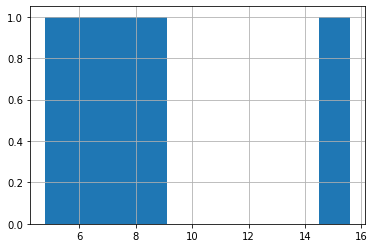

In [149]:
results_df['Stationary_Arm_Range'].hist()

In [132]:
results_df.iloc[:, -4:].mean(), results_df.iloc[:, -4:].median()

(Moving_Arm_Range        92.536460
 Moving_Leg_Range        81.174434
 Stationary_Arm_Range     8.519382
 Stationary_Leg_Range    19.541808
 dtype: float64,
 Moving_Arm_Range        90.423085
 Moving_Leg_Range        83.283371
 Stationary_Arm_Range     7.633713
 Stationary_Leg_Range    11.824647
 dtype: float64)

In [141]:
frames = [31, 42, 19, 39, 45, 24]
BODY_25 = [8.832841, 10.578062, 6.950953, 10.058543, 10.862436, 7.248979]
COCO = [9.021137, 9.055004, 6.841755, 9.413278, 9.339426, 7.281852]
MPI = [8.101413, 9.011844, 6.666194, 9.281861, 9.091507, 7.343933]

print(np.mean(np.array(BODY_25)/np.array(frames)))
print(np.mean(np.array(COCO)/np.array(frames)))
print(np.mean(np.array(MPI)/np.array(frames)))



# per_frame_body_25, per_frame_coco, per_frame_mpi = [], [], []
# for num_frames, body_25_time, coco_time, mpi_time in zip(frames, BODY_25, COCO, MPI):
#     per_frame_body_25.append()


0.28399470379549474
0.2698352539455545
0.2621305110701087


In [144]:
from scipy.stats import ttest_ind
print(ttest_ind(
    np.array(BODY_25)/np.array(frames),
    np.array(COCO)/np.array(frames)
))

print(ttest_ind(
    np.array(BODY_25)/np.array(frames),
    np.array(MPI)/np.array(frames)
))

Ttest_indResult(statistic=0.4642387410881323, pvalue=0.6524186854751622)
Ttest_indResult(statistic=0.7314337818492024, pvalue=0.48130251024006)
